# compare the optimization performance of SSE and LSE based on iterative CTSM simulations

In [1]:
import sys, os, glob, pickle, toml, json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax


def cal_ratio_within_bins(data, bins):
    binsc = np.zeros(len(bins)-1)
    ratio = np.zeros(len(bins)-1)
    for i in range(len(bins)-1):
        indi = (data>bins[i]) & (data<=bins[i+1])
        ratio[i] = np.sum(indi)/np.sum(~np.isnan(data))
        binsc[i] = (bins[i]+bins[i+1])/2
    return binsc, ratio

# Load data

In [2]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

In [3]:
# input/out and iteration information
iternum = 4
inpath_moasmo = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/'
outpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out'

In [4]:
# LSE metrics
outfile = f'{outpath}/LSE_627basin_CTSM_4iter_optmz_metrics.csv.gz'
if os.path.isfile(outfile):
    df_lse_metric = pd.read_csv(outfile, compression='gzip')
else:
    df_lse_metric = []

    for tarbasin in range(len(df_info)):
    # for tarbasin in range(5):
        for i in range(iternum):
            infile = f'{inpath_moasmo}/level1_{tarbasin}_MOASMOcalib/ctsm_outputs_emutest/iter{i}_many_metric.csv'    
            dfi = pd.read_csv(infile)
            dfi['basin'] = tarbasin
            dfi['iter'] = i
            dfi['trial'] = np.arange(len(dfi))
            if len(df_lse_metric) == 0:
                df_lse_metric = dfi
            else:
                df_lse_metric = pd.concat([df_lse_metric, dfi])
                
    df_lse_metric.to_csv(outfile, index=False, compression='gzip')

In [5]:
# SSE metrics
outfile = f'{outpath}/SSE_627basin_CTSM_4iter_optmz_metrics.csv.gz'
if os.path.isfile(outfile):
    df_sse_metric = pd.read_csv(outfile, compression='gzip')
else:
    df_sse_metric = []
    for tarbasin in range(len(df_info)):
        for i in range(iternum):
            infile = f'{inpath_moasmo}/level1_{tarbasin}_MOASMOcalib/ctsm_outputs_normKGE/iter{i}_many_metric.csv' 
            if not os.path.isfile(infile):
                print('Warning! File does not exist:', infile)
                # this is not always good
                dfi = dfi.copy()
                dfi[:] = np.nan 
            else:
                dfi = pd.read_csv(infile)
            dfi['basin'] = tarbasin
            dfi['iter'] = i
            dfi['trial'] = np.arange(len(dfi))
            if len(df_sse_metric) == 0:
                df_sse_metric = dfi
            else:
                df_sse_metric = pd.concat([df_sse_metric, dfi])
                
    df_sse_metric.to_csv(outfile, index=False, compression='gzip')

In [6]:
# check if mismatch exists
diff = [df_lse_metric[i].values - df_sse_metric[i].values for i in ['basin','iter','trial'] ]
if np.any(np.array(diff) != 0):
    print('Mismatch between LSE and SSE metrics')
else:
    print('LSE and SSE metrics match each other')

LSE and SSE metrics match each other


In [7]:
# get the performance of default parameters in each basin (1st trial in iter-0)
index = (df_lse_metric['iter']==0) & (df_lse_metric['trial']==0)
df_defa_metric = df_lse_metric[index]
df_defa_metric.index = np.arange(len(df_defa_metric))
print(len(df_defa_metric))

if np.any(df_sse_metric[index].values[:,0] != df_defa_metric.values[:,0]):
    print('Mismatch in default parameter values')
else:
    print('Default parameter metrics match')

627
Default parameter metrics match


# Overall improvements of each iteration

In [8]:
metname = 'kge'
met_stats_lse = np.nan * np.zeros([len(df_info), iternum, 3]) # best; mean; median
for i in range(iternum):
    indi = (df_lse_metric['iter']==i)
    for j in range(len(df_info)):
        indij = indi & (df_lse_metric['basin']==j)
        dij = df_lse_metric[indij][metname].values

        met_stats_lse[j, i, 0] = np.nanmax(dij)
        met_stats_lse[j, i, 1] = np.nanmean(dij)
        met_stats_lse[j, i, 2] = np.nanmedian(dij)


met_stats_sse = np.nan * np.zeros([len(df_info), iternum, 3]) # best; mean; median
for i in range(iternum):
    indi = (df_sse_metric['iter']==i)
    for j in range(len(df_info)):
        indij = indi & (df_sse_metric['basin']==j)
        dij = df_sse_metric[indij][metname].values

        met_stats_sse[j, i, 0] = np.nanmax(dij)
        met_stats_sse[j, i, 1] = np.nanmean(dij)
        met_stats_sse[j, i, 2] = np.nanmedian(dij)

/glade/derecho/scratch/guoqiang/tmp/ipykernel_55552/3018273369.py:21: RuntimeWarning: All-NaN slice encountered
  met_stats_sse[j, i, 0] = np.nanmax(dij)
/glade/derecho/scratch/guoqiang/tmp/ipykernel_55552/3018273369.py:22: RuntimeWarning: Mean of empty slice
  met_stats_sse[j, i, 1] = np.nanmean(dij)
/glade/derecho/scratch/guoqiang/tmp/ipykernel_55552/3018273369.py:23: RuntimeWarning: All-NaN slice encountered
  met_stats_sse[j, i, 2] = np.nanmedian(dij)


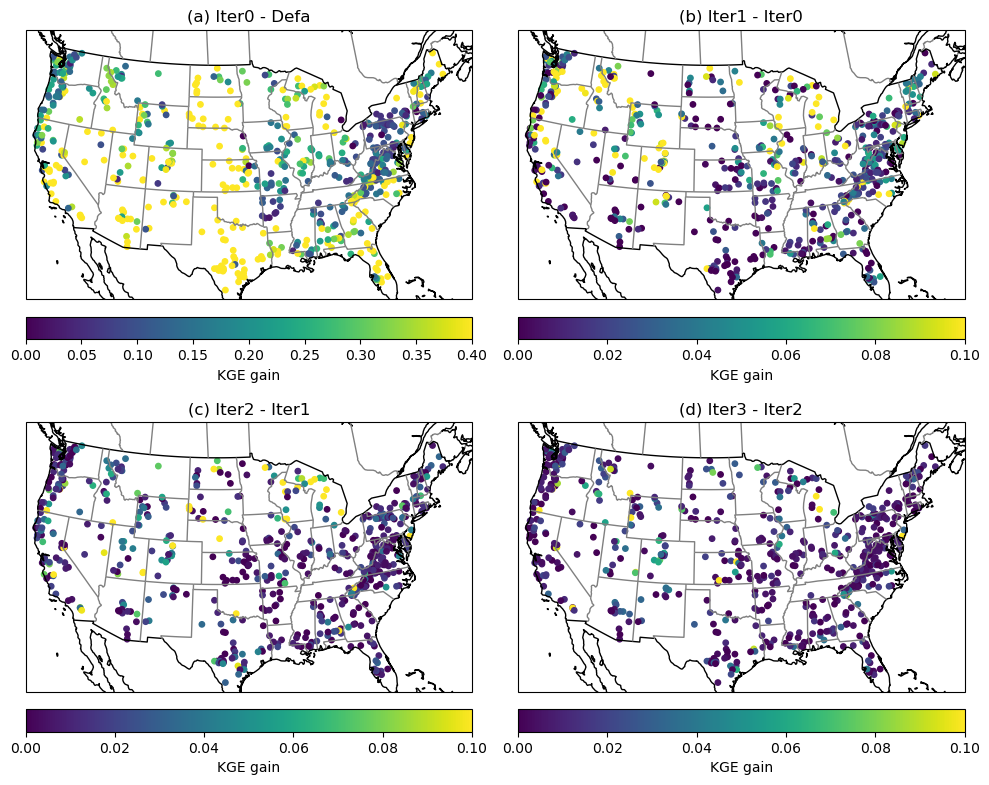

In [100]:
# LSE improvement against 

dplot = []
for i in range(iternum):
    if i==0:
        dplot.append(met_stats_lse[:,i,0] - df_defa_metric[metname].values)
    else:
        dplot.append(met_stats_lse[:,i,0] - met_stats_lse[:,i-1,0])

vmins = [0, 0, 0, 0]
vmaxs = [0.4, 0.1, 0.1, 0.1]
title = ['(a) Iter0 - Defa', '(b) Iter1 - Iter0', '(c) Iter2 - Iter1', '(d) Iter3 - Iter2']

lat, lon = df_info['lat_cen'].values, df_info['lon_cen'].values

fig = plt.figure(figsize=[10, 8])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, dplot[i],  vmin = vmins[i], vmax=vmaxs[i], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label="KGE gain", pad=0.05)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
plt.savefig('LSE_4iter_KGEgain_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

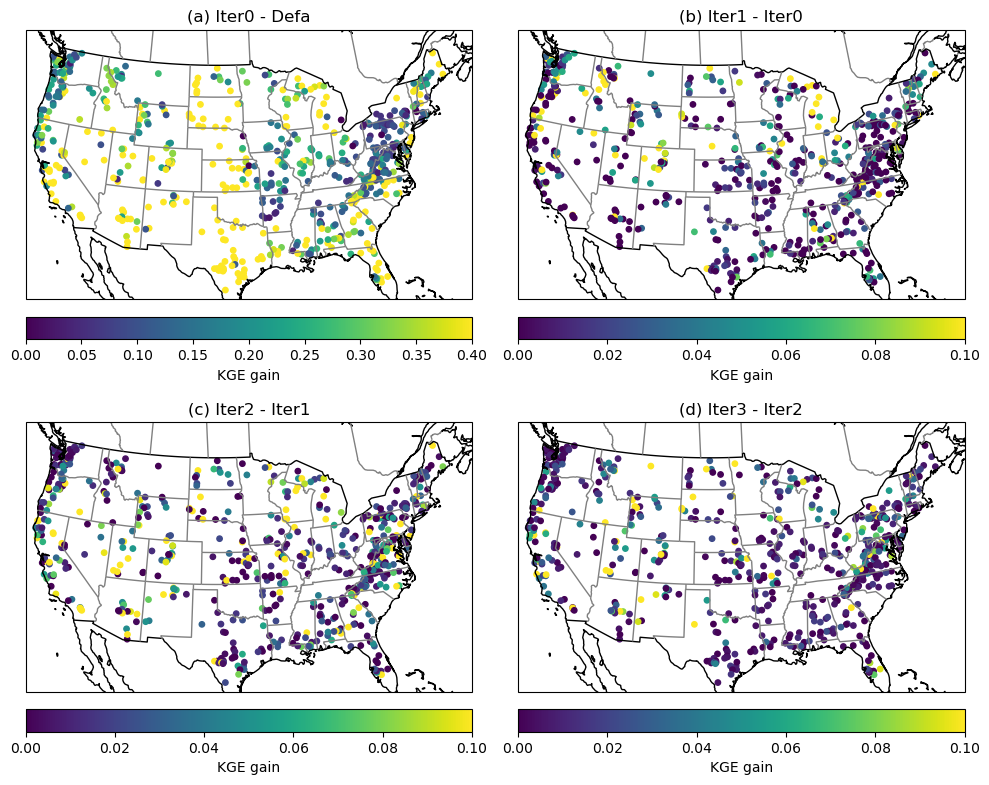

In [101]:
# SSE improvement against 

dplot = []
for i in range(iternum):
    if i==0:
        dplot.append(met_stats_sse[:,i,0] - df_defa_metric[metname].values)
    else:
        dplot.append(met_stats_sse[:,i,0] - met_stats_sse[:,i-1,0])

vmins = [0, 0, 0, 0]
vmaxs = [0.4, 0.1, 0.1, 0.1]
title = ['(a) Iter0 - Defa', '(b) Iter1 - Iter0', '(c) Iter2 - Iter1', '(d) Iter3 - Iter2']

lat, lon = df_info['lat_cen'].values, df_info['lon_cen'].values

fig = plt.figure(figsize=[10, 8])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(lon, lat, 15, dplot[i],  vmin = vmins[i], vmax=vmaxs[i], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label="KGE gain", pad=0.05)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
plt.savefig('SSE_4iter_KGEgain_map.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [107]:
# ratio of basins improve against the previous iter
ratio = np.nan * np.zeros([iternum, 2]) # sse/lse
mag = np.nan * np.zeros([iternum, 2, 2]) # sse/lse; mean/median
din = [met_stats_sse, met_stats_lse]
for i in range(iternum):
    for j in range(2):
        if i == 0:
            mag[i,j,0] = np.nanmean(din[j][:,i,0] - df_defa_metric[metname].values)
            mag[i,j,1] = np.nanmedian(din[j][:,i,0] - df_defa_metric[metname].values)
            ratio[i,j] = np.sum(din[j][:,i,0]>df_defa_metric[metname].values) / len(df_info)
        else:
            mag[i,j,0] = np.nanmean(din[j][:,i,0] - din[j][:,i-1,0])
            mag[i,j,1] = np.nanmedian(din[j][:,i,0] - din[j][:,i-1,0])
            ratio[i,j] = np.sum(din[j][:,i,0]>din[j][:,i-1,0]) / len(df_info)

print(ratio)
print('mean', mag[:,:,0])
print('median', mag[:,:,0])

[[0.99362041 0.99362041]
 [0.57894737 0.80861244]
 [0.81020734 0.83732057]
 [0.79106858 0.84529506]]
mean [[ 1.59649540e+00  1.59649540e+00]
 [-8.81230566e-04  4.65529827e-02]
 [ 3.98501775e-02  2.29271490e-02]
 [ 2.20909522e-02  1.60301560e-02]]
median [[ 1.59649540e+00  1.59649540e+00]
 [-8.81230566e-04  4.65529827e-02]
 [ 3.98501775e-02  2.29271490e-02]
 [ 2.20909522e-02  1.60301560e-02]]


In [111]:
# improvement magnitude
for i in range(3):
    print(np.nanmean(met_stats_lse[:,:,i],axis=0))
    print(np.nanmean(met_stats_sse[:,:,i],axis=0))

[0.38360896 0.43016195 0.4530891  0.46911925]
[0.38360896 0.38272773 0.4241375  0.44622845]
[-0.78649342  0.32712021  0.36150423  0.29764143]
[-0.78649342  0.28868224  0.35179585  0.38062103]
[-0.49698201  0.33923257  0.38024579  0.39795285]
[-0.49698201  0.30167409  0.36333949  0.40017927]


# Comapre LSE and SSE

In [23]:
# met_stats_lse  # best; mean; median

# for each iter, how many basins where best(lse) is better than best(sse)
ratio1 = np.zeros(iternum-1)
for i in range(1, 4): # no need to consider iter-0 
    ratio1[i-1] = np.sum(met_stats_lse[:,i, 0] > met_stats_sse[:,i, 0] ) / np.sum(~np.isnan(met_stats_lse[:,i, 0]))


# for each iter, how many basins where lse/sse improve against its previous iteration
# note that for sse, iter-1 is a low benchmark, partly contributing to high iter-2 (and maybe iter-3?)
ratio2 = np.zeros([iternum-1, 2])
for i in range(1, 4): # no need to consider iter-0 
    ratio2[i-1, 0] = np.sum(met_stats_lse[:,i, 0] > met_stats_lse[:,i-1, 0] ) / np.sum(~np.isnan(met_stats_lse[:,i, 0]))
    ratio2[i-1, 1] = np.sum(met_stats_sse[:,i, 0] > met_stats_sse[:,i-1, 0] ) / np.sum(~np.isnan(met_stats_sse[:,i, 0]))

# what is the improvement of iter-1 .. against iter-0 (LHS)
kge_impr_vs0 = np.zeros([len(df_info), 2, iternum-1])
for i in range(1, 4): # no need to consider iter-0 
    kge_impr_vs0[:,0,i-1] =  met_stats_lse[:,i,0] - met_stats_lse[:,0,0]
    kge_impr_vs0[:,1,i-1] =  met_stats_sse[:,i,0] - met_stats_sse[:,0,0]

# what is the optimal kge after all iterations
kge_best = np.zeros([len(df_info), 2])
dtmplse = np.hstack([met_stats_lse[:,:,0], df_defa_metric[metname].values[:, np.newaxis]])
kge_best[:,0] = np.nanmax(dtmplse, axis=1)
dtmpsse = np.hstack([met_stats_sse[:,:,0], df_defa_metric[metname].values[:, np.newaxis]])
kge_best[:,1] = np.nanmax(dtmpsse, axis=1)


In [22]:
np.nanmean(kge_best,axis=0), np.nanmedian(kge_best,axis=0)

(array([0.47318214, 0.45703846]), array([0.52932271, 0.51841538]))

In [25]:
np.nanmean(kge_impr_vs0[:,0,:],axis=0), np.nanmean(kge_impr_vs0[:,1,:],axis=0)

(array([0.04655298, 0.06948013, 0.08551029]),
 array([-0.00088123,  0.03881943,  0.06091039]))

In [ ]:
# Plot the number of basins improve against the previous iterations



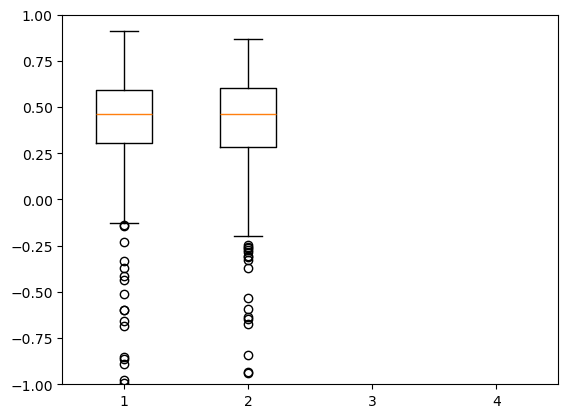

In [50]:
# plt.boxplot(1, df_defa_metric[metname].values)
# plt.boxplot([ df_defa_metric[metname].values, met_stats_sse[:,0,0] ])
plt.boxplot(met_stats_sse[:,:,0])

plt.ylim(-1,1)
plt.show()

In [53]:
# np.nanmean(met_stats_sse[:,:,0], axis=0)
np.nanmedian(met_stats_sse[:,:,0], axis=0)

array([0.46116677, 0.46508245, 0.49349101, 0.5140363 ])

In [65]:
np.sum(met_stats_sse[:,3,0]>met_stats_sse[:,2,0])

496

In [66]:
np.sum(met_stats_sse[:,3,0]>met_stats_sse[:,2,0]) / len(df_info)

0.7910685805422647

In [67]:
np.sum(met_stats_lse[:,3,0]>met_stats_lse[:,2,0]) / len(df_info)

0.8452950558213717

In [54]:
np.nanmedian(met_stats_lse[:,:,0], axis=0)

array([0.46116677, 0.50478524, 0.51495102, 0.52538579])

# Present the improvement of LSE iterations

## different iterations

In [63]:
metname = 'kge'
approach = 'max'

labels = ['defa']
for i in range(iternum):
    labels.append(f'iter-{i}')

metric_all = []
metric_all.append(df_defa_metric[metname].values)
for i in range(iternum):
    indi = df_lse_metric['iter']==i
    metric_all.append(df_lse_metric[metname][indi].values)

metric_optmz = np.nan * np.zeros([len(df_info), iternum+1])
metric_optmz[:,0] = df_defa_metric[metname].values
for i in range(iternum):
    indi = (df_lse_metric['iter']==i)
    for j in range(len(df_info)):
        indij = indi & (df_lse_metric['basin']==j)
        dij = df_lse_metric[indij][metname].values
        if approach == 'max':
            metric_optmz[j, i+1] = np.nanmax(dij)
        elif approach == 'min':
            metric_optmz[j, i+1] = np.nanmin(dij)

print(labels)
print(np.nanmean(metric_optmz, axis=0))
print(np.nanmedian(metric_optmz, axis=0))

['defa', 'iter-0', 'iter-1', 'iter-2', 'iter-3']
[-1.22636562  0.38221157  0.43016195  0.4530891   0.46911925]
[0.19671281 0.46116677 0.50478524 0.51495102 0.52538579]


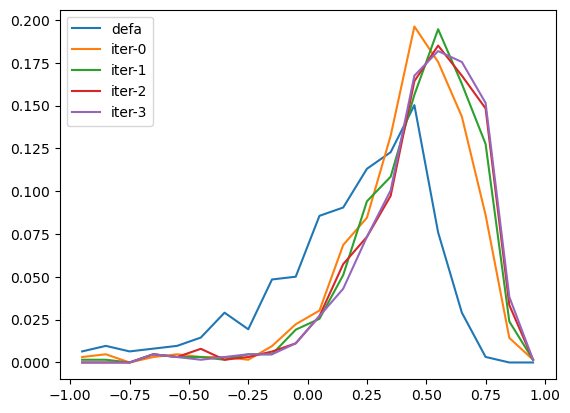

In [68]:
bins0 = np.arange(-1, 1.1, 0.1)

for i in range(metric_optmz.shape[1]):
    bins, dm = cal_ratio_within_bins(metric_optmz[:,i], bins0)
    plt.plot(bins, dm, label=labels[i])

plt.legend()
plt.show()

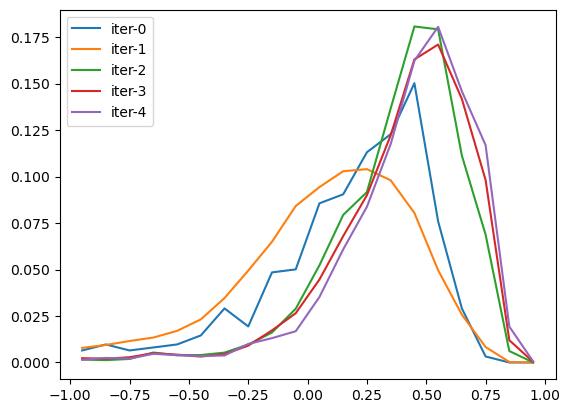

In [60]:
# this may not be good
# should calculate the improvement of each basin and iteration
bins0 = np.arange(-1, 1.1, 0.1)

for i in range(len(dataplot)):
    bins, dm = cal_ratio_within_bins(dataplot[i], bins0)
    plt.plot(bins, dm, label=f'iter-{i}')

plt.legend()
plt.show()

## Example basins of LSE optmz

In [235]:
# -24 shows that iter-3 has much larger spread than iter-1 and iter-2 and reaches better performance
# -26 shows that all iter-0 is worse than defa, but following iterations optimize parameter
# -27 shows a good increase rate, but iter-3 has some negative KGEs, indicating the unrobustness of emulator and the need of multiple optmz outputs
# -5; -30 shows a very good example
# it deserves to plot all basins to check their interesting patterns

# select a basin
lastdiff = metric_optmz[:,-1] - metric_optmz[:,-2]

useind = [-5, -30, -27, -26]
indtar_all = [np.argsort(lastdiff)[i] for i in useind]
print(indtar_all)
# print(metric_optmz[indtar, :])

[310, 428, 485, 257]


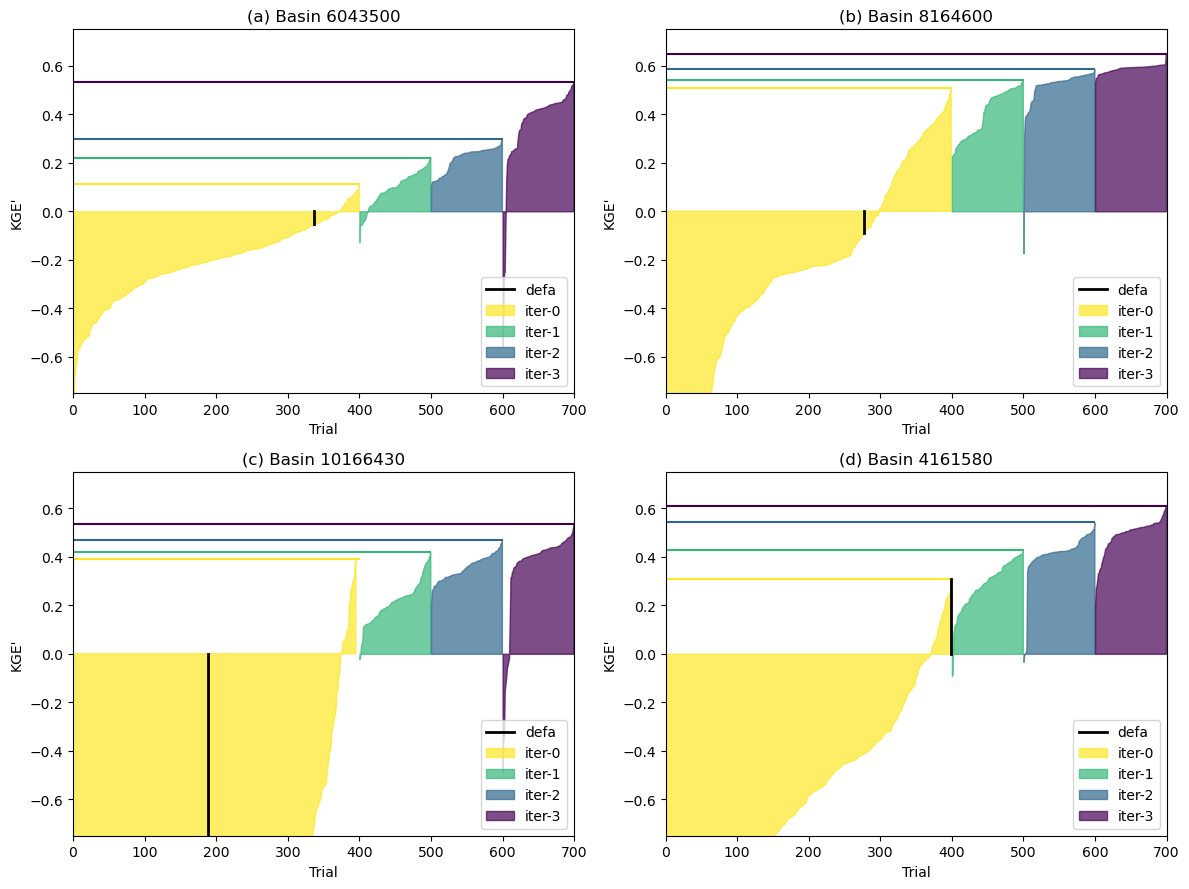

In [245]:
# plot selected basins

idall = [df_info.iloc[i]['hru_id'] for i in indtar_all]
titles = 'abcd'
titles = [f'({titles[i]}) Basin {idall[i]}' for i in range(len(idall))]


# Create a colormap
cmap = plt.get_cmap('viridis_r', iternum)
    
# Create a figure and axis
fig, axs = plt.subplots(2, 2, figsize=[12, 9])
axs = axs.flatten()
    

for b in range(len(indtar_all)):

    ax = axs[b]

    indtar = indtar_all[b]

    df_tar = df_lse_metric[df_lse_metric['basin']==indtar]
    df_tar.index = np.arange(len(df_tar))
    
    for i in range(iternum):
        dfi = df_tar[df_tar['iter'] == i]
        x, y = dfi.index, dfi['kge'].values
        indi = np.argsort(y)
        
        # Sort x and y based on the sorted indices
        x_sorted, y_sorted = x, y[indi]
        
        # Use fill_between to create a filled plot
        ax.fill_between(x_sorted, y_sorted, color=cmap(i / iternum), label=f'iter-{i}', alpha=0.7)
    
        ax.plot([0, x_sorted[-1]], [np.nanmax(y_sorted), np.nanmax(y_sorted)], color=cmap(i / iternum))
        
    # Plot the default line last to ensure it's on top, but collect its handle first
    dfi = df_tar[df_tar['iter'] == 0]
    xdefa = np.sum(dfi['kge'].values[0] > dfi['kge'].values)
    default_handle, = ax.plot([xdefa, xdefa], [0, dfi['kge'].values[0]], color='k', linewidth=2, label='defa')
    
    # set axis
    ax.set_ylim(-0.75, 0.75)
    ax.set_xlim(0, len(df_tar))
    ax.set_ylabel("KGE'")
    ax.set_xlabel('Trial')

    ax.set_title(titles[b])
    
    # Collect all legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    
    # Reorder the handles and labels to ensure 'defa' is first
    handles = [default_handle] + handles[:-1]
    labels = ['defa'] + labels[:-1]
    
    # Create the legend
    ax.legend(handles, labels, loc='lower right')

plt.tight_layout()
plt.savefig('LSE_4iter_optmz_4basins.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()